In [3]:
!pip install seaborn


   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   - -------------------------------------- 10.2/294.9 kB ? eta -:--:--
   ---- ---------------------------------- 30.7/294.9 kB 325.1 kB/s eta 0:00:01
   ----- --------------------------------- 41.0/294.9 kB 326.8 kB/s eta 0:00:01
   -------- ------------------------------ 61.4/294.9 kB 363.1 kB/s eta 0:00:01
   -------------- ----------------------- 112.6/294.9 kB 544.7 kB/s eta 0:00:01
   ------------------ ------------------- 143.4/294.9 kB 532.5 kB/s eta 0:00:01
   ------------------------- ------------ 194.6/294.9 kB 620.6 kB/s eta 0:00:01
   ----------------------------- -------- 225.3/294.9 kB 687.0 kB/s eta 0:00:01
   ------------------------------------ - 286.7/294.9 kB 679.3 kB/s eta 0:00:01
   -------------------------------------- 294.9/294.9 kB 674.6 kB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
pip install xgboost



   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/56.8 MB 330.3 kB/s eta 0:02:52
   ---------------------------------------- 0.1/56.8 MB 365.7 kB/s eta 0:02:36
   ---------------------------------------- 0.1/56.8 MB 403.5 kB/s eta 0:02:21
   ---------------------------------------- 0.1/56.8 MB 450.6 kB/s eta 0:02:06
   ---------------------------------------- 0.2/56.8 MB 510.2 kB/s eta 0:01:52
   ---------------------------------------- 0.2/56.8 MB 525.1 kB/s eta 0:01:48
   ---------------------------------------- 0.2/56.8 MB 525.1 kB/s eta 0:01:48
   ---------------------------------------- 0.2/56.8 MB 554.9 kB/s eta 0:01:42
   ---------------------------------------- 0.3/56.8 MB 678.1 kB/s eta 0:01:24
   ---------------------------------------- 0.4/56.8 MB 696.3 kB/s eta 0:01:22

In [5]:
from sklearn.model_selection import KFold, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans

# Optional: LightGBM/XGBoost
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

In [7]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")


In [9]:
print(train.shape, test.shape)
print(train.info())
print(train.describe())


(18154, 21) (4323, 20)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18154 entries, 0 to 18153
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   house_id              18154 non-null  int64  
 1   sale_date             18154 non-null  object 
 2   num_bedrooms          18154 non-null  int64  
 3   num_bathrooms         16702 non-null  float64
 4   living_area           18154 non-null  float64
 5   lot_area              18154 non-null  float64
 6   num_floors            18154 non-null  float64
 7   is_waterfront         18154 non-null  int64  
 8   view_rating           16702 non-null  float64
 9   condition_index       18154 non-null  object 
 10  construction_grade    18154 non-null  object 
 11  above_area            18154 non-null  float64
 12  basement_area         16702 non-null  float64
 13  built_year            18154 non-null  int64  
 14  renovated_year        16702 non-null  object 
 

In [11]:
if 'sale_date' in train.columns:
    train['sale_year'] = pd.to_datetime(train['sale_date']).dt.year
    train['sale_month'] = pd.to_datetime(train['sale_date']).dt.month
    test['sale_year'] = pd.to_datetime(test['sale_date']).dt.year
    test['sale_month'] = pd.to_datetime(test['sale_date']).dt.month


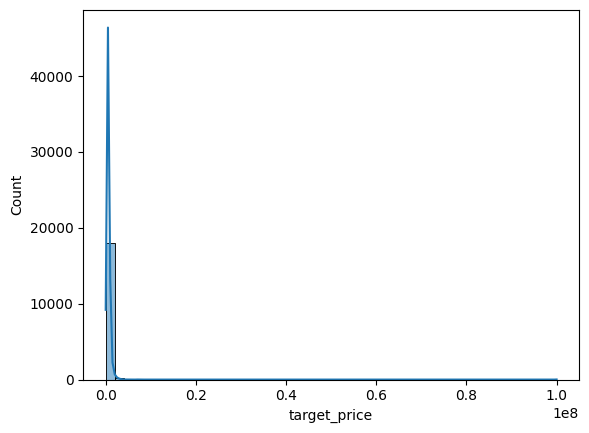

In [13]:
sns.histplot(train['target_price'], bins=50, kde=True)
plt.show()

In [15]:
y = train['target_price']
if y.skew() > 1:
    y_log = np.log1p(y)  # log1p for skewed target
else:
    y_log = y

C:\Users\sasan\Anaconda\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\sasan\Anaconda\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [17]:
train['age'] = train['sale_year'] - train['built_year']
test['age'] = test['sale_year'] - test['built_year']

In [19]:
# Convert renovated_year to numeric, coerce errors to NaN
train['renovated_year'] = pd.to_numeric(train['renovated_year'], errors='coerce')
test['renovated_year'] = pd.to_numeric(test['renovated_year'], errors='coerce')

# Fill missing or invalid values with 0 (if that makes sense for your dataset)
train['renovated_year'] = train['renovated_year'].fillna(0)
test['renovated_year'] = test['renovated_year'].fillna(0)

# Now calculate yrs_since_reno
train['yrs_since_reno'] = np.where(train['renovated_year'] > 0,
                                   train['sale_year'] - train['renovated_year'],
                                   0)
test['yrs_since_reno'] = np.where(test['renovated_year'] > 0,
                                  test['sale_year'] - test['renovated_year'],
                                  0)


In [21]:
train['area_ratio'] = train['living_area'] / (train['lot_area'] + 1)
test['area_ratio'] = test['living_area'] / (test['lot_area'] + 1)

In [23]:
train['has_basement'] = (train['basement_area'] > 0).astype(int)
test['has_basement'] = (test['basement_area'] > 0).astype(int)

In [25]:
coords = pd.concat([train[['latitude','longitude']],
                    test[['latitude','longitude']]])
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(coords)
train['coord_cluster'] = kmeans.predict(train[['latitude','longitude']])
test['coord_cluster'] = kmeans.predict(test[['latitude','longitude']])

In [26]:
train.replace([np.inf, -np.inf], np.nan, inplace=True)
test.replace([np.inf, -np.inf], np.nan, inplace=True)


In [27]:
numeric_features = ['age','yrs_since_reno','living_area','lot_area','area_ratio',
                    'basement_area','neighbor_living_area','neighbor_lot_area']

for col in numeric_features:
    train[col] = pd.to_numeric(train[col], errors='coerce')
    test[col] = pd.to_numeric(test[col], errors='coerce')


In [31]:
categorical_features = ['zip_area','has_basement','coord_cluster']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

In [33]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

In [35]:
ridge_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', Ridge(alpha=1.0))
])

In [37]:
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42))
])

In [39]:
lgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LGBMRegressor(n_estimators=1000, learning_rate=0.05, random_state=42))
])

In [41]:
# Replace invalid target values
y = train['target_price'].copy()

# Remove rows with missing or non-positive target
mask_valid = y > 0
X_train_clean = train.loc[mask_valid]
y_clean = y.loc[mask_valid]

# Apply log-transform safely
y_log_clean = np.log1p(y_clean)


In [43]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

def rmse_cv(model, X=X_train_clean, y=y_log_clean):
    scores = -cross_val_score(model, X, y, cv=kf,
                              scoring='neg_root_mean_squared_error')
    return scores.mean()


In [ ]:
print("Ridge RMSE:", rmse_cv(ridge_pipeline))
print("RandomForest RMSE:", rmse_cv(rf_pipeline))
print("LightGBM RMSE:", rmse_cv(lgb_pipeline))



In [46]:
param_grid = {
    'model__n_estimators':[100,200,300],
    'model__max_depth':[None,10,20,30],
    'model__min_samples_split':[2,5,10],
    'model__min_samples_leaf':[1,2,4]
}

In [ ]:
search = RandomizedSearchCV(rf_pipeline, param_distributions=param_grid,
                            n_iter=20, cv=kf, scoring='neg_root_mean_squared_error',
                            random_state=42, n_jobs=-1, verbose=2)

search.fit(train, y_log)
print("Best params:", search.best_params_)
print("Best RMSE:", -search.best_score_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
